In [1]:
import imageio
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import gc
from scipy import misc
import glob
import cv2
# from i3d_inception import Inception_Inflated3d
# from i3d_inception import conv3d_bn
from numpy.random import seed
seed(1)
import matplotlib
matplotlib.use('Agg')
import os
import h5py
import scipy.io as sio
import gc

from keras.models import load_model, Model, Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
		 	  Activation, Dense, Dropout, ZeroPadding2D)
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from keras.layers.advanced_activations import ELU
import keras
from keras import layers
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file

from keras import optimizers
print ("successfully imported")

Using TensorFlow backend.


successfully imported


In [2]:
## fun
def rgb2grey(pic):
    size = np.shape(pic)
    pic = np.array(pic)
    W = size[0]
    H = size[1]
    rim = pic[:,:,0]
    gim = pic[:,:,1]
    bim = pic[:,:,2]
    return  0.299 * rim + 0.587 * gim + 0.114 * bim


In [3]:
def generator(list1, lits2):
    '''
    Auxiliar generator: returns the ith element of both given list with each call to next() 
    '''
    for x,y in zip(list1,lits2):
        yield x, y

Image shape:  (224, 224, 3)


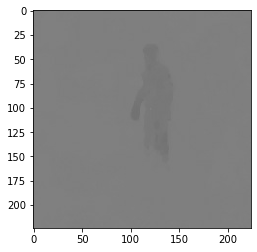

In [4]:
# test
%matplotlib inline 
image_size=244
frame = 10
strid = frame//5
NUM_RGB_CHANNELS = 3
NUM_CLASSES = 2

I = tf.read_file("URFD_opticalflow/Falls/fall_fall-01/flow_x_00001.jpg")
I = tf.image.decode_jpeg(I, channels=3) 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    I=sess.run((I))
#     print (I.shape) 
#     print (I)
    plt.imshow(I) 
# I.resize((image_size,image_size))
print ('Image shape: ',np.shape(I))

In [5]:
# load mean
mean_file = 'flow_mean.mat'
d = sio.loadmat(mean_file)
flow_mean = d['image_mean']

In [6]:

#floders 
im_folders1 = glob.glob('URFD_opticalflow/Falls//fall*')
im_folders2 = glob.glob('URFD_opticalflow/NotFalls//notfall*')
im_folders3 = im_folders1+im_folders2
np.random.shuffle(im_folders3)

#print(im_folders1)
#print(im_folders2)
# print(im_folders3)
final_data = np.empty(shape=(0,224,224,2*frame))
final_label = []

In [7]:
# loop all the files
for i,folder in enumerate(im_folders3[0:1]):
    print (i,folder)
    flow_x =  glob.glob(folder+'//flow_x*')
    flow_x.sort()
    flow_y =  glob.glob(folder+'//flow_y*')
    flow_y.sort()
    nb_stacks = len(flow_x)-frame + 1 # total number of flow groups, one group has frame # images.
    flow = np.zeros(shape=(224,224,2*frame,nb_stacks), dtype=np.float64)
    gen = generator(flow_x,flow_y)  # yield single x and y image 
    
    for i in range(len(flow_x)):
        flow_x_file, flow_y_file = gen.__next__()
        img_x = cv2.imread(flow_x_file, cv2.IMREAD_GRAYSCALE)
        img_y = cv2.imread(flow_y_file, cv2.IMREAD_GRAYSCALE)
        # Assign an image i to the jth stack in the kth position, but also
        # in the j+1th stack in the k+1th position and so on
        # (for sliding window)
        for s in list(reversed(range(min(10,i+1)))):
            if i-s < nb_stacks:
                flow[:,:,2*s,  i-s] = img_x
                flow[:,:,2*s+1,i-s] = img_y
        del img_x,img_y
#         gc.collect()
    del flow_x, flow_y
    # Subtract mean
    flow = flow - np.tile(flow_mean[...,np.newaxis],(1, 1, 1, flow.shape[3]))
    flow = np.transpose(flow, (3, 0, 1, 2)) 
    final_data=np.concatenate((final_data,flow),axis=0)
    #opflow_set = [xyxyxyxyxyxyxyxy]

    temp_label =[]
    frame_n = len(flow)
    del flow
    
    # detect whether the opflow is in fall folder or notfall folder
    if folder in im_folders1:
        temp_label+=[1]*frame_n
    else:
        temp_label+=[0]*frame_n
    
    final_label.append(temp_label)
    print("label size:",np.size(temp_label))

0 URFD_opticalflow/NotFalls\notfall_fall-20_post
label size: 53


In [8]:
# above is label porcess    
final_data = np.array(final_data[:])
final_label = sum(final_label, []) ## flatten
print("final_lebel",np.shape(final_label))
print("final_data",np.shape(final_data))

final_lebel (53,)
final_data (53, 224, 224, 20)


In [9]:
final_data_size = np.shape(final_label)
final_data_size = final_data_size[0]

# here we choose divide data into 7:3, 
# 7 for training and 3 for test
trainx = final_data[:int(final_data_size*0.7)]
trainy = final_label[:int(final_data_size*0.7)]

testx = final_data[int(final_data_size*0.7):]
testy = final_label[int(final_data_size*0.7):]

# # transpose the size of opflow data
# trainx = trainx.transpose(0,3,2,1)   #
# testx = testx.transpose(0,3,2,1)   #

print('trainx shape:',np.shape(trainx))
print('trainy shape:',np.shape(trainy))

print('testx shape:',np.shape(testx))
print('testy shape:',np.shape(testy))

trainx shape: (37, 224, 224, 20)
trainy shape: (37,)
testx shape: (16, 224, 224, 20)
testy shape: (16,)


In [10]:
# hyper parameters
learning_rate = 0.0001

In [11]:
num_features = num_features = 4096

model = Sequential()

model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 20)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(num_features, name='fc6', kernel_initializer='glorot_uniform'))

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(4096, name='fc2', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add( Dense(1, name='predictions',kernel_initializer='glorot_uniform'))
model.add(Activation('sigmoid'))

adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999,
    epsilon=1e-08)
model.compile(optimizer=adam, loss='binary_crossentropy',
      metrics=['accuracy'])

W0412 21:16:58.743080  2852 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0412 21:16:58.745075  2852 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0412 21:16:58.765024  2852 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0412 21:16:58.821871  2852 deprecation_wrapper.py:119] From c:\users\cc\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf

In [12]:
model.summary()   # plot the structure of rgb model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 20)      0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      11584     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)    

In [13]:
print(np.shape(trainx))
model.fit(trainx,trainy,validation_data=(testx,testy), batch_size=10, shuffle=True,epochs=1)


(37, 224, 224, 20)
Train on 37 samples, validate on 16 samples
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training/Adam/mul_131}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
